In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 32
version = 1

In [2]:
!pip install -Uqq fastai fastbook nbdev

In [2]:
from fastai import *
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from timm import create_model

In [3]:
vehicle_labels = [
    # Cars & Light Vehicles
    "Pickup truck", "SUV", "Van / Minivan", "Station wagon",
    "Convertible", "Sports car", "Hatchback", "Coupe", "Sedan", 
    "Limousine", "Taxi", "Police car", "Ambulance", "Fire truck",

    # Trucks & Utility
    "Light truck", "Heavy truck", "Semi truck", "Tow truck", 
    "Garbage truck", "Cement mixer truck", "Dump truck",
    "Refrigerated truck", "Flatbed truck", "Tanker truck",

    # Mass Transport
    "Bus", "Mini-bus", "School bus", "Coach bus", 
    "Tram", "Train", "Subway train",

    # Two- & Three-Wheelers
    "Bicycle", "Motorcycle", "Scooter", "Moped", "Dirt bike",
    "Three-wheeler", "Tricycle",

    # Agriculture & Construction
    "Tractor", "Combine harvester", "Bulldozer", "Excavator",
    "Backhoe loader", "Skid steer", "Forklift", 
    "Road roller", "Crane",

    # Aircraft
    "Airplane", "Helicopter", "Glider", "Hot air balloon",
    "Drone", "Jet", "Cargo aircraft", "Seaplane",

    # Watercraft
    "Boat", "Ship", "Sailboat", "Yacht", "Speedboat",
    "Fishing boat", "Cargo ship", "Cruise ship",
    "Submarine", "Kayak", "Jet ski",

    # Non-Motorized / Animal-Drawn
    "Carriage", "Rickshaw", "Handcart", 
    "Wheelchair", "Skateboard", "Roller skates"
]

In [5]:
%pip install -U duckduckgo_search fastai fastcore tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
# from tqdm.notebook import tqdm # helps keep track of the progress

data_path = "data"
# if not os.path.exists(data_path):
#   os.mkdir(data_path)

# for vehicle_type in tqdm(vehicle_labels):

#   dest = f"{data_path}/{vehicle_type}"
#   if not os.path.exists(dest):
#     os.mkdir(dest)

#   try:
#     vehicle_image_urls = search_images_ddg(vehicle_type, max_images=50)
#     download_images(dest, urls = vehicle_image_urls)

#   except:
#     continue

In [26]:
image_counts = get_image_files(data_path)
image_counts

(#5132) [Path('data/Airplane/03759c06-778e-4942-8bbd-17f61af7865d.jpg'),Path('data/Airplane/05263b75-3aa5-4674-8c79-5eb9eac39065.jpg'),Path('data/Airplane/060f4916-b0f8-4bbb-8c46-372995ff4ad9.jpg'),Path('data/Airplane/0cb64cfd-9951-4db0-b945-abe797e09a47.jpg'),Path('data/Airplane/168236f8-25fc-4b13-80c5-63d045bff872.jpg'),Path('data/Airplane/18807de5-6bcd-4a75-a442-203962069cf4.jpg'),Path('data/Airplane/1b522346-7f07-4a52-9a54-b803cde65576.jpg'),Path('data/Airplane/1dddf379-4398-43aa-8db3-c73d22ef08b9.png'),Path('data/Airplane/1eeb9e7c-49c0-4888-9285-d2a9750f463d.jpg'),Path('data/Airplane/211be0d6-1b1e-4ddf-81d9-ab833c5d9f06.jpg'),Path('data/Airplane/270b19ce-a999-49b8-a128-df33bf2b7845.jpg'),Path('data/Airplane/2a710e06-bc69-4349-993f-4e4bcfe270e6.png'),Path('data/Airplane/2b4e49f6-f2ca-46bd-b271-2cf65d9bdbbf.jpg'),Path('data/Airplane/2e3b82ff-2ed3-4108-a460-b4ceed37c78e.jpg'),Path('data/Airplane/3d8319c8-2df5-4199-8b4a-263152c9a6f5.jpg'),Path('data/Airplane/4150dfc8-d8b3-4c06-b336-87

In [8]:
failed = verify_images(image_counts)
failed

(#0) []

In [9]:
failed.map(Path.unlink)

(#0) []

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,                        
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))   

In [6]:
dls = dblock.dataloaders(data_path,bs=bs)  

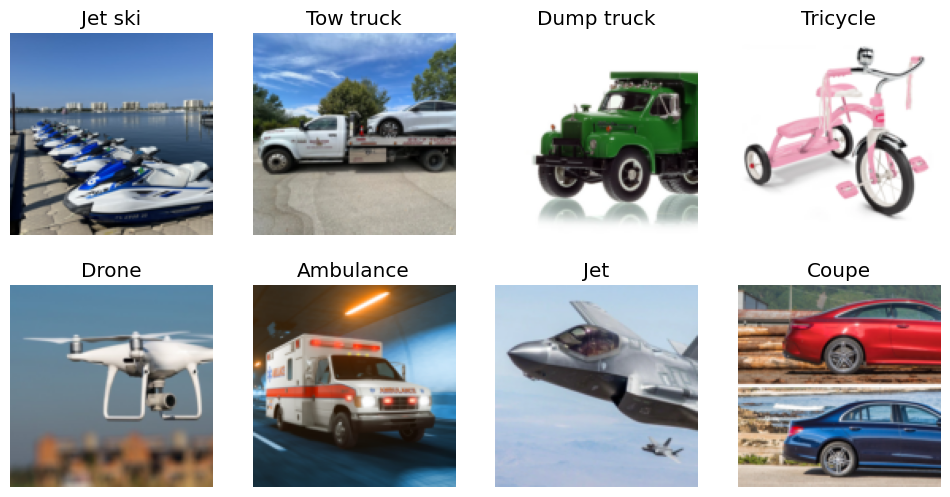

In [7]:
dls.train.show_batch(max_n=8, nrows=2)

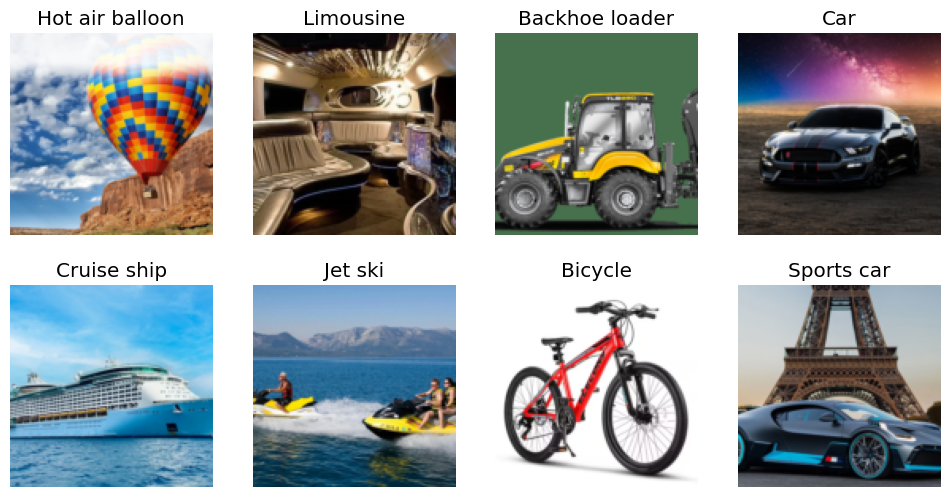

In [13]:
dls.valid.show_batch(max_n=8, nrows=2)

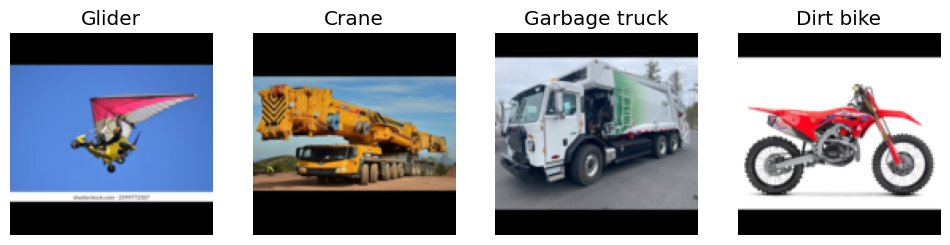

In [8]:
dblock = dblock.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')) # Padding the extra spaced the whole image into (128 x 128) size without squishing
dls = dblock.dataloaders(data_path)
dls.valid.show_batch(max_n=4, nrows=1)

In [15]:
torch.save(dls, "cap_dataloader_v0.pkl")

In [9]:
model_path = "models"

In [10]:
model = vision_learner(dls, 'convnext_tiny_in22k', metrics=[error_rate,accuracy], path = model_path)

c:\Users\USERAS\Desktop\Works\projects\fastai\vehicle_classification\venv\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


c:\Users\USERAS\Desktop\Works\projects\fastai\vehicle_classification\venv\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


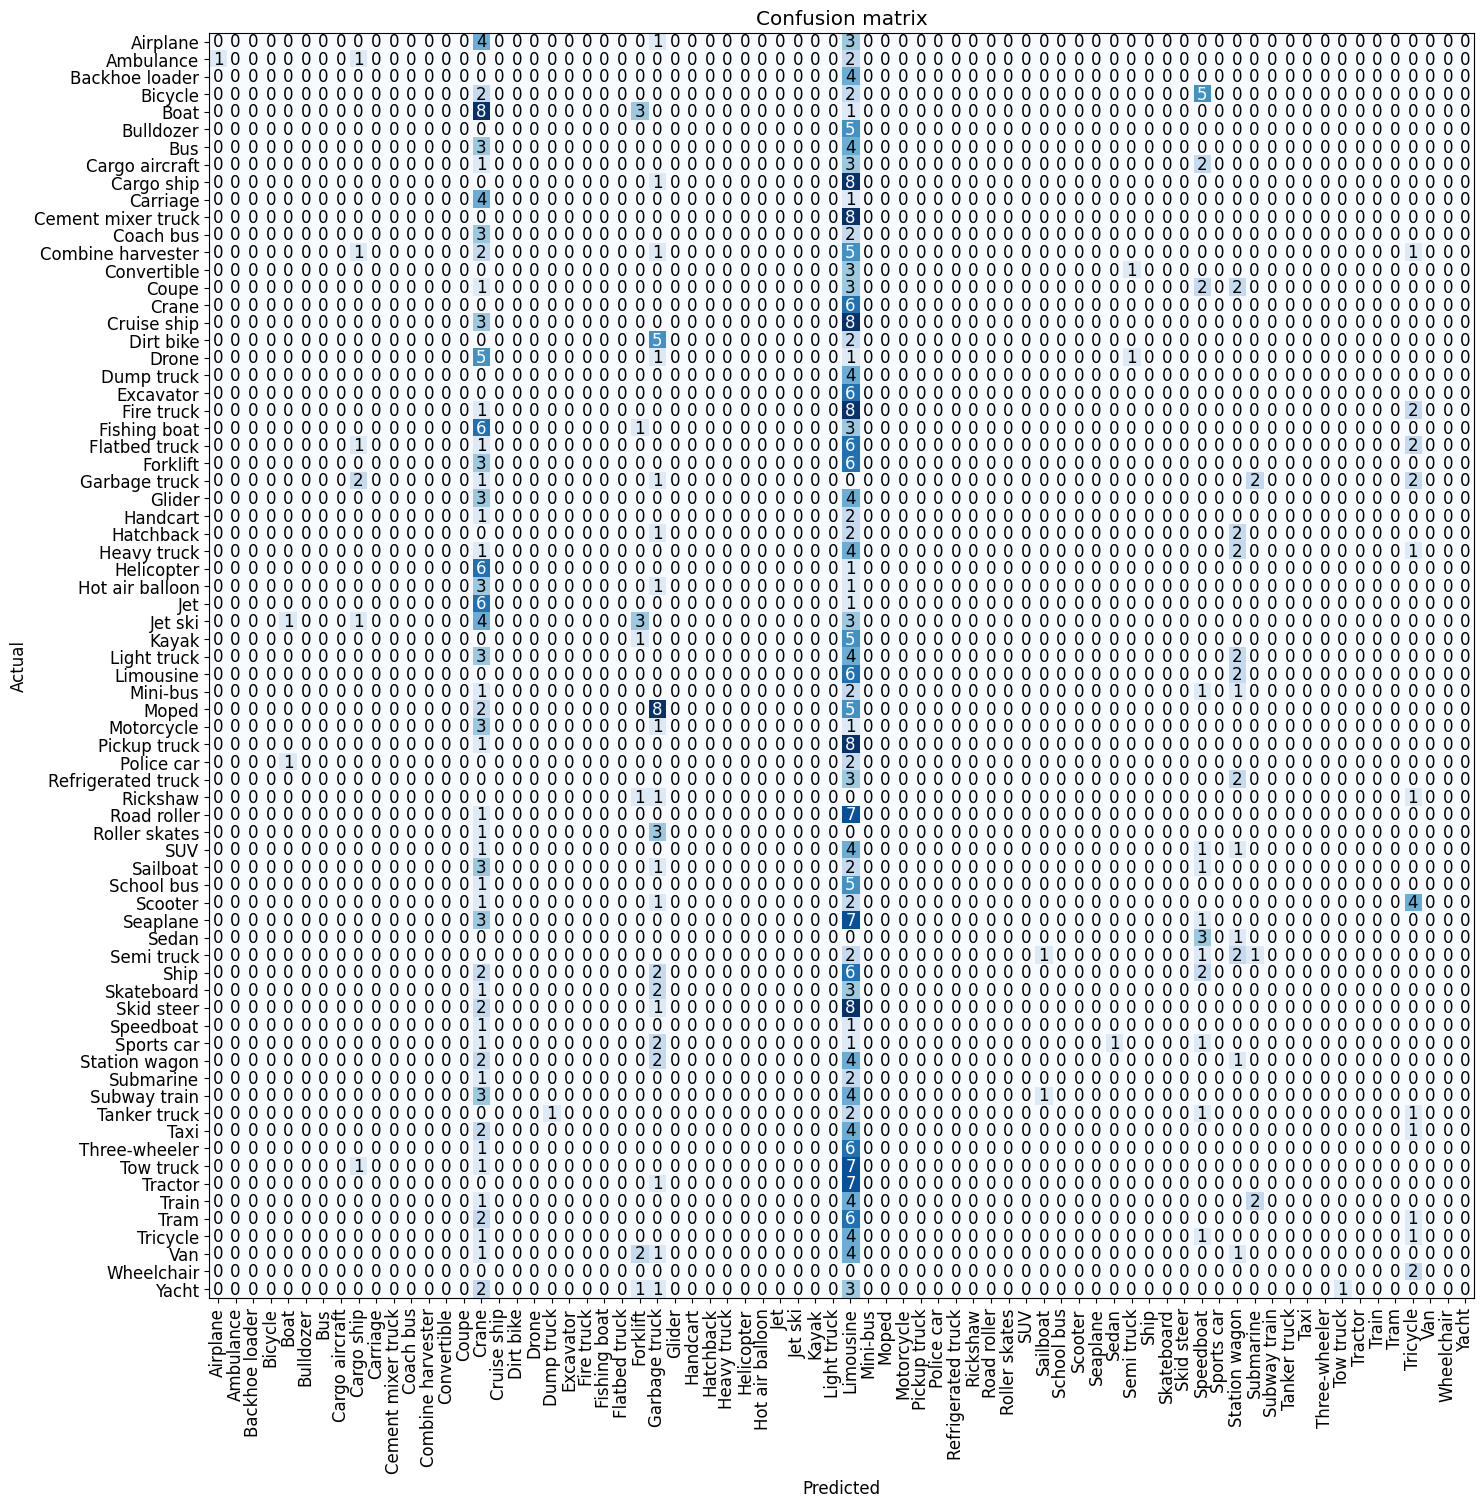

In [11]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(15,15))

In [19]:
cleaner = ImageClassifierCleaner(model)
cleaner

c:\Users\USERAS\Desktop\Works\projects\fastai\vehicle_classification\venv\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [22]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), f'{data_path}/{cat}')

In [11]:
model.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.807590,0.859289,0.269006,0.730994,05:02


c:\Users\USERAS\Desktop\Works\projects\fastai\vehicle_classification\venv\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.766046,0.504061,0.148148,0.851852,06:21


In [13]:
model.save(f"vehicle_classification-v{version}")

Path('models/models/vehicle_classification-v1.pth')